# Panoramsko spajanje slika

Definicija problema: *Kako iskombinovati mnostvo slika sa preklapanjima i kreirati jednu vecu sliku - panoramu.*

Ovaj problem sastoji se od nekoliko koraka:
1. Izdvanjanje skupa zajednickih tacaka i njihovo uparivanje, odnosno, prepoznavanje geometrijske veze izmedju slika
<br><img src="images/feature_extraction.png" alt="Feature extraction" width="700"/>

2. Izracunavanje homografije. Homografija je transformacija kojom se jedna slika prebacuje u svet druge slike - prakticno poravnanje slika.
Nakon ovog koraka dobiju se slike koje su "nadovezane" jedna na drugu.
<br><img src="images/stiched_image.png" alt="Feature extraction" width="700"/>

3. Stapanje slika, jer slike skoro nikada nece biti slikane sa istom ekspozicijom
<br><br><img src="images/blending.png" alt="Feature extraction" width="500"/>

4. Opcioni korak u kom se po potrebi od dobijenog rezultata izvlaci najbolja moguca pravougaona slika sa sto manje gubitaka podataka

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def draw_image(image, width=15, height=10):
    plt.figure(figsize=(width, height))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

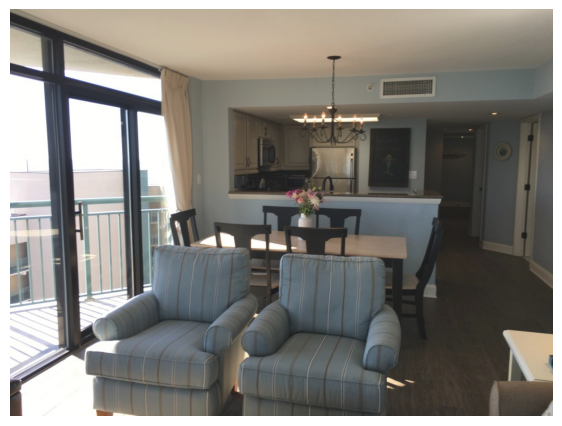

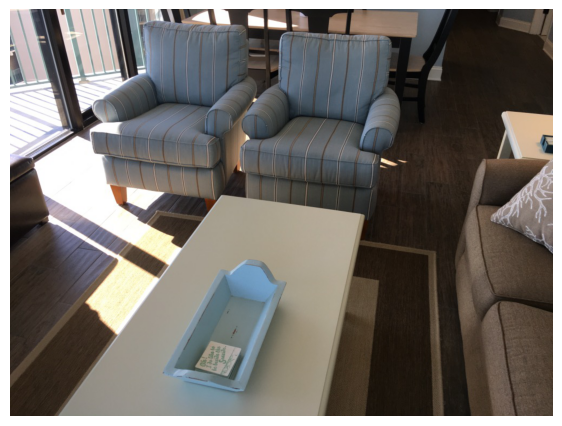

In [4]:
# Ucitavanje primera za demonstraciju funkcija
image_1_bgr = cv.imread('./images/image_1.jpg')
image_2_bgr = cv.imread('./images/image_2_b.jpg') # slika namerno posvetljena radi demonstracije drugacije ekspozicije

image_1 = cv.cvtColor(image_1_bgr, cv.COLOR_BGR2RGB)
image_2 = cv.cvtColor(image_2_bgr, cv.COLOR_BGR2RGB)

draw_image(image_2, 7, 10)
draw_image(image_1, 7, 10)

## 1. Izdvajanje skupa zajednickih tacaka i njihovo uparivanje

Prvi problem koji treba resiti je izracunavanje kljucnih tacaka na slikama.

**Ključne tačke** su posebne tačke koje imaju karakteristicne i prepoznatljive osobine, kao i imaju jedinstvenu poziciju na slici.

One su interesantne zato što se lako mogu naći i pratiti u različitim slikama, čak i ako su slike rotirane, skalirane ili slikane pod razlicitim osvetljenjem.
Primer kljucnih tacaka: vrh trougla ili slova na slici.

</br>
Uz njih, potrebno je izracunati i deskriptore.

**Deskriptori** su brojevi koji numericki opisuju izgled okoline neke kljucne tacke na slici i veoma su vazni za uparivanje kljucnih tacaka izmedju slika.

Dakle, dok ključna tačka predstavlja poziciju na slici, deskriptor je detaljan opis tog mesta.

Zahvaljujuci njima algoritmi su otporni na sve promene objekta (rotacije, skaliranja i sl) na razlicitim slikama.
</br></br>


Neki od algoritama za detekciju ključnih tačaka i formiranje deskriptora:
1. **Harris Corner Detector** - Detektuje uglove na slici. Nije otporan na promene skaliranja ili rotacije, ali je brz i jednostavan.

2. **SIFT (Scale-Invariant Feature Transform)** - Pronalazi ključne tačke i opisuje ih tako da su invarijantne na promene veličine, rotacije i osvetljenja. Vrlo popularan i pouzdan, ali relativno spor.

3. **SURF (Speeded-Up Robust Features)** - Brža verzija SIFT-a, takođe invarijantna na skaliranje i rotaciju.

4. **ORB (Oriented FAST and Rotated BRIEF)** - Brz i efikasan algoritam, često se koristi kao besplatna alternativa za SIFT i SURF (ali su oba od skoro dostupna zajednici).
</br></br>

Kada su izracunate kljucne tacke i deskriptori za obe slike potrebno ih je upariti na odgovarajuci nacin.

Pristupi za uparivanje:
1. **Brute-Force Matcher (BFMatcher)** - Upoređuje svaki deskriptor sa svim deskriptorima na drugoj slici. Koristi metrike poput Euklidskog rastojanja (za SIFT, SURF) ili Hamingovog rastojanja (za ORB). Spor, ali vrlo jednostavan.

2. **FLANN (Fast Library for Approximate Nearest Neighbors)** - Efikasniji algoritam za pronalaženje najbližih suseda u velikim skupovima podataka. Koristi se za brže i skalabilnije uparivanje. Popularan za SIFT i SURF.
</br></br>

Kao dodatak na oba algoritma potrebno je na neki nacin isfiltrirati lazna podudaranja izmedju deskriptora kljucnih tacaka dve slike, jer za svaku tacku prve slike bice nekoliko potencijalnih poklapanja na drugoj slici od kojih ce dosta njih biti "lazni". 

Za to se koristi **Lowe’s ratio test**. Kako on funkcionise:
1. Za svaku ključnu tačku iz prve slike pronađi dva najbolja (najbliža) para na drugoj slici — tj. dva deskriptora sa najmanjom udaljenosti.

2. Izračunaj odnos distance prvog i drugog najboljeg poklapanja:

$$
\displaystyle ratio = \frac {\text{distanca najboljeg para}} {\text{distanca drugog najboljeg para}} 
$$

3. Ako je ovaj odnos manji od određenog praga (obično 0.75), to znači da je najbolji par mnogo bolji od drugog, pa ga treba prihvatiti


4. Ako je odnos veći ili jednak pragu, znači da najbolji par nije dovoljno jedinstven i odbacuje se.

### FLANN Matcher i SIFT algoritam

Za dalji rad isproban je FLANN algoritam buduci da je prvi pristup spor i neefikasan za prakticnu upotrebu.
On je efikasan jer koristi kompleksnije strukture podataka (KD stabla) da brzo pronadje "dovoljno dobre" najblize susede.

Kako on radi?

1. Indeksira skup podataka (deskriptore druge slike) u specijalizovanu strukturu (kao što su KD-stabla ili hash tabele).

2. Kada traži najbližeg suseda za neki deskriptor, koristi ovu strukturu da brzo suzi pretragu.

3. Rezultat nije uvek apsolutno najbliži sused, već aproksimacija, ali dovoljno dobra i znatno brža nego.
</br></br>

Uz FLANN, odabran je SIFT algoritam za izracunavanje deskriptora jer je vrlo pouzdan i robustan, a dovoljno brzo radi i lepo se kombinuje sa FLANN algoritmom.

Takodje, bice prikazano i unapedjenje kada je za k najblizih suseda izabrano k > 1.

In [7]:
def evaluate_matches(matches):
    if not matches:
        return 0
   
    distances = [m.distance for m in matches]
    avg_distance = sum(distances) / len(distances)
    max_distance = max(distances)

    return round(avg_distance, 2), round(max_distance, 2)

225.37 is the average distance of the matches
439.53 is the maximum distance of the matches


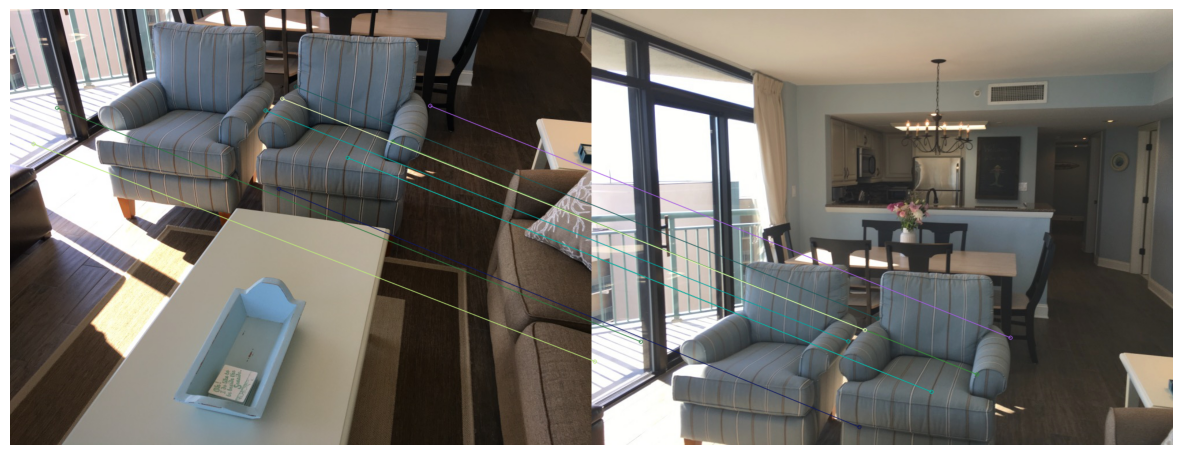

In [19]:
def calculate_flann(image_1, image_2, drawOutput=False):
    sift = cv.SIFT_create()
    
    # pronalazenje kljucnih tacaka i deskriptora pomocu SIFT algoritma
    key_points_1, desc_1 = sift.detectAndCompute(image_1, None)
    key_points_2, desc_2 = sift.detectAndCompute(image_2, None)
    
    # FLANN parametri za KD stabla. trees = 10 je broj stabala koja se koriste za pretragu - sto ih je vise, to je sporije, ali i preciznije
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)

    # koliko puta treba obici stablo - sto je veci broj, to je sporije, ali i tacnije
    search_params = dict(checks = 100)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)

    # Izracunavanje najboljih parova deskriptora izmedju dve slike
    matches = flann.match(desc_1, desc_2)
    
    # Sortiranje parova po rastojanju
    matches = sorted(matches, key = lambda x:x.distance)
    avg_distance, max_distance = evaluate_matches(matches)
    print(avg_distance, "is the average distance of the matches")
    print(max_distance, "is the maximum distance of the matches")

    if drawOutput:
        # Plotovanje prvih 10 parova
        matches_to_draw = matches[:10]
        plot_image_FLANN = cv.drawMatches(image_1, key_points_1, image_2, key_points_2, matches_to_draw, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        draw_image(plot_image_FLANN)

calculate_flann(image_1, image_2, drawOutput=True)

128.4 is the average distance of the matches
312.77 is the maximum distance of the matches


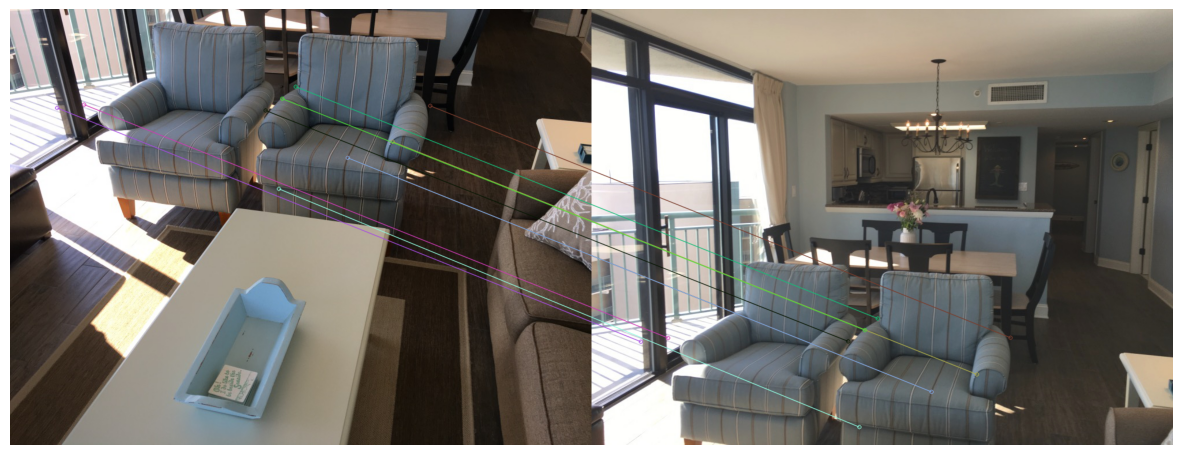

In [21]:
# unapredjenje sa trazenjem k najboljih upraivanja. k = 2 kako bismo mogli da primenimo spomenuti Lowe's ratio test
def calculate_kp_and_desc_knn(image_1, image_2, k=2, drawOutput=False, lowes_ratio_treshold=0.75):
    sift = cv.SIFT_create()
    
    key_points_1, desc_1 = sift.detectAndCompute(image_1, None)
    key_points_2, desc_2 = sift.detectAndCompute(image_2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
    search_params = dict(checks = 100)
    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches_knn = flann.knnMatch(desc_1, desc_2, k=k)
    good_matches = []

    # Lowe's ratio test
    for _, (x_s, y_s) in enumerate(matches_knn):
        if x_s.distance < lowes_ratio_treshold * y_s.distance:
            good_matches.append(x_s)
    
    # Sortiranje parova po rastojanju (zbog iscrtavanja)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    
    if drawOutput:
        plot_image_FLANN_knn = cv.drawMatches(image_1, key_points_1, image_2, key_points_2, good_matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        avg_distance, max_distance = evaluate_matches(good_matches)
        print(avg_distance, "is the average distance of the matches")
        print(max_distance, "is the maximum distance of the matches")

        draw_image(plot_image_FLANN_knn)

    return good_matches, key_points_1, key_points_2

img_matches, kp_1, kp_2 = calculate_kp_and_desc_knn(image_1, image_2, drawOutput=True)

Iz grubog i jednostavnog testa za evaluaciju resenja koji se svodi na racunanje prosecnog i najveceg rastojanja dobijenih parova vidi se da se sa K=2 najboljih uparavanja algoritam za nijansu bolje ponasa (prikazani parovi izgledaju dobro u oba slucaja), te ce u nastavku taj rezultat biti koriscen.

In [22]:
# iz uparivanja se izdvajaju polazne i krajnje tacke
img_1_points = np.float32([kp_1[m.queryIdx].pt for m in img_matches]).reshape(-1,1,2)
img_2_points = np.float32([kp_2[m.trainIdx].pt for m in img_matches]).reshape(-1,1,2)

## 2. Izracunavanje homografije

Homografija je matrica transformacija koja prevodi jednu ravan u drugu ravan kroz tacku projekcije (tacka kamere).
<br><br><img src="images/homography_composition.png" alt="Feature extraction" width="500"/>

Pretpostavka koju moramo uvesti ovde je da:
1. Tacke scene leze na istoj ravni
2. Tacke su slikane iz iste tacke (tacke kamere)
3. **Tacke su veoma udaljene** (sto je najcesci slucaj kada su u pitanju panorame, jer retko ce slike biti uslikane bez imalo pomeranja kamere)

U nastavku ce prvo biti dato korak po korak izracunavanje homografije iz teorije upotrebom numpy biblioteke, a nakon toga primer racunanja homografije u openCV biblioteci radi poredjenja rezultata.

### Postavka problema i korak po korak implementacija

Ako imamo tacku Ps koja predstavlja tacku izvora sa prve slike i Pd koje je tacka destinacije na drugoj slici, tada imamo projektivno preslikavanje:

\begin{bmatrix}x_d \\ y_d \\ 1 \end{bmatrix} = \begin{bmatrix}\tilde{x_d} \\ \tilde{y_d} \\ \tilde{z_d} \end{bmatrix} = \begin{bmatrix}h_{11} && h_{12} && h_{13} \\ h_{21} && h_{22} && h_{23} \\ h_{31} && h_{32} && h_{33} \end{bmatrix} \begin{bmatrix}x_s \\ y_s \\ 1 \end{bmatrix}

Minimum parova tacaka koji nam je potreban za izracunavanje homografije je 4 (jer zbog osobina homogenih koordinata mozemo da eliminisemo jednu pa imamo 8 nepoznathih), ali uvek zelimo da upotrebimo sto vise kako bismo dobili sto precizniju homografiju.

Za par tacaka sa indeksom i:

$$
\displaystyle x_d^{(i)} = \frac{\tilde{x_d}^{(i)}}{\tilde{z_d}^{(i)}} = \frac{h_{11}x_s^{(i)} + h_{12}y_s^{(i)} + h_{13}}{h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33}}
$$

$$
\displaystyle y_d^{(i)} = \frac{\tilde{y_d}^{(i)}}{\tilde{z_d}^{(i)}} = \frac{h_{21}x_s^{(i)} + h_{22}y_s^{(i)} + h_{23}}{h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33}}
$$

Zapisano u malo drugacijem formatu:

$$
\displaystyle x_d^{(i)} (h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33}) = h_{11}x_s^{(i)} + h_{12}y_s^{(i)} + h_{13}
$$

$$
\displaystyle y_d^{(i)} (h_{31}x_s^{(i)} + h_{32}y_s^{(i)} + h_{33} )= h_{21}x_s^{(i)} + h_{22}y_s^{(i)} + h_{23}
$$

I zapisano u matricnom obliku:
\begin{bmatrix}x_s^{(i)} && y_s^{(i)} && 1 && 0 && 0 && 0 && -x_d{(i)}x_s{(i)} && -x_d{(i)}y_s{(i)} && -x_d{(i)} \\ 0 && 0 && 0 && x_s^{(i)} && y_s^{(i)} && 1 && -y_d{(i)}x_s{(i)} && -y_d{(i)}y_s{(i)} && -y_d{(i)} \end{bmatrix} \begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32} \\ h_{33}\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}

Ako to ukombinujemo sa svih datih n tacaka:
\begin{bmatrix}x_s^{(1)} && y_s^{(1)} && 1 && 0 && 0 && 0 && -x_d{(1)}x_s{(1)} && -x_d{(1)}y_s{(1)} && -x_d{(1)} \\ 0 && 0 && 0 && x_s^{(1)} && y_s^{(1)} && 1 && -y_d{(1)}x_s{(1)} && -y_d{(1)}y_s{(1)} && -y_d{(1)} \\ \vdots \\ x_s^{(i)} && y_s^{(i)} && 1 && 0 && 0 && 0 && -x_d{(i)}x_s{(i)} && -x_d{(i)}y_s{(i)} && -x_d{(i)} \\ 0 && 0 && 0 && x_s^{(i)} && y_s^{(i)} && 1 && -y_d{(i)}x_s{(i)} && -y_d{(i)}y_s{(i)} && -y_d{(i)} \\ \vdots \\ x_s^{(n)} && y_s^{(n)} && 1 && 0 && 0 && 0 && -x_d{(n)}x_s{(n)} && -x_d{(n)}y_s{(n)} && -x_d{(n)} \\ 0 && 0 && 0 && x_s^{(n)} && y_s^{(n)} && 1 && -y_d{(n)}x_s{(n)} && -y_d{(n)}y_s{(n)} && -y_d{(n)}\end{bmatrix} \begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32} \\ h_{33}\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ 0 \\ \vdots \\ 0 \\ 0\end{bmatrix}

Pa sustinski treba resiti $A h = 0$, sa dodatim uslovom da je $||h||^2 = 1$



In [25]:
def build_matrix_A(src_points, dest_points):
    """
    Funkcija koja racuna prethodno opisanu matricu A.

    Parametri:
    src_pts: lista tacaka iz izvora [(x1_s, y1_s), (x2_s, y2_s), ...]
    dest_pts: lista tacaka destinacije [(x1_d, y1_d), (x2_d, y2_d), ...]

    Povratna vrednost:
    Matrica A.
    """

    src_pts = np.squeeze(src_points)
    dest_pts = np.squeeze(dest_points)

    rows = []
    for (x_s, y_s), (x_d, y_d) in zip(src_pts, dest_pts):
        row1 = [x_s, y_s, 1, 0, 0, 0, -x_d * x_s, -x_d * y_s, -x_d]
        row2 = [0, 0, 0, x_s, y_s, 1, -y_d * x_s, -y_d * y_s, -y_d]
        rows.append(row1)
        rows.append(row2)

    return np.array(rows, dtype=np.float64)

A = build_matrix_A(img_1_points, img_2_points)
print('Matrica A:\n', A)

Matrica A:
 [[ 5.85006226e+02  2.57629822e+02  1.00000000e+00 ... -3.44608719e+05
  -1.51761609e+05 -5.89068481e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.88074688e+05
  -1.70903500e+05 -6.63368469e+02]
 [ 4.94884827e+02  1.34321884e+02  1.00000000e+00 ... -2.45349906e+05
  -6.65929922e+04 -4.95771729e+02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.52582359e+05
  -4.75336094e+04 -1.58524475e+02]
 [ 5.39924805e+02  2.22020931e+01  1.00000000e+00 ... -2.89791469e+05
  -1.19164316e+04 -5.36725586e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.35544312e+05
  -9.68575000e+03 -4.36253906e+02]]


### Izracunavanje $A h = 0$, kada je $||h||^2 = 1$

Resava se metodom najmanjih kvadrata sa organicenjem.
Definicija problema:

$$
\displaystyle \min\limits_{h} ||Ah||^2 \text{ tako da je } \displaystyle ||h||^2 = 1
$$

Ono sto znamo je da:

$$
\displaystyle ||Ah||^2 = (Ah)^T(Ah) = h^TA^TAh \text{ i } ||h||^2 = h^Th = 1
$$

Tako da ono sto trazimo je zapravo:

$$
\displaystyle \min\limits_{h} (h^TA^TAh) \text{ tako da je } \displaystyle h^Th = 1
$$

Za ovo nam je potreban metod Lagranzevih multiplikatora. Osnovna ideja je da se problem sa organicenjem svede na neogranicen problem kako bi se mogli primeniti testovi pomocu izvoda da bi se nasao minimum. Veza izmedju gradijenta funkcije i organicenja u opstem obliku izgleda ovako:

$$
\displaystyle {\mathcal {L}}(x,\lambda )\equiv f(x)+\langle \lambda ,g(x)\rangle
$$

i vrednost **$\lambda$** se zove upravo Lagranzev multiplikator.

U nasem slucaju, funkcija greske izgleda ovako:

$$
\displaystyle {\mathcal {L}}(h,\lambda )\equiv h^TA^TAh + \lambda\langle h^Th - 1 \rangle
$$

Kada izracunamo prvi izvod ove funkcije po h i izjednacimo sa 0 kako bismo dobili stacionarne tacke funkcije:

$$
2A^TAh - 2\lambda h = 0
$$

odnosno

$$
2A^TAh = 2\lambda h
$$

sto je zapravo problem sopstvenih vrednosti i sopstvenih vektora matrice A.

**Konacno, sopstveni vektor h sa najmanjom sopstvenom vrednoscu $\lambda$ matrice $A^TA$ minimizuje funkciju greske $L(h)$.**

Kada se vektor h zapise kao 3x3 matrica dobija se trazena homografija.

In [26]:
def compute_homography(A):
    ATA = A.T @ A
        
    eigen_values, eigen_vectors = np.linalg.eigh(ATA)

    # indeks najmanje sopstvene vrednosti
    idx = np.argmin(eigen_values)
    h = eigen_vectors[:, idx]

    # normalizacija (da ||h|| = 1)
    h = h / np.linalg.norm(h)

    return h.reshape(3, 3)

H_simple = compute_homography(A)
print('Homografija:\n', H_simple)

Homografija:
 [[-2.58807431e-04  1.31536443e-03 -3.88185559e-01]
 [ 6.48841700e-04  1.43406333e-03 -9.21577350e-01]
 [ 9.68811375e-07  3.14499130e-06 -1.69870549e-03]]


### Sta raditi sa anomalijama medju parovima tacaka?

Vrlo cesto ce nam algoritmi za prepoznavanje pored odgovarajucih tacaka dati i neke pogresne rezultate koji nam mogu pokvariti rezultat.
Sa njima se takodje treba pozabaviti i za to se koristi tehnika koja se zove **RANSAC** (Random sample consensus) algoritam.
RANSAC algoritam postoji jos od ranih 80-tih godina proslog veka i ima razne upotrebe. Veoma je mocan - moze se desiti da postoji veliki broj anomalija medju tackama i on ce se odlicno izboriti, sve dok broj anomalija ne prelazi 50% ukupnog broja tacaka.

Koraci u RANSAC algoritmu:
1. Nasumicno odabrati N tacaka
2. Ubaciti nasumicno odabrane tacke u model
3. Definisati prihvatljivu gresku $\epsilon$ i prebrojati koji broj tacaka - M ce primenom modela imati gresku manju od $\epsilon$
4. Ponavljati korake 1-3 K puta
5. Odabrati onaj model koji ima najveci broj M

U primeru homografije:
1. Odaberemo nasumicno 4 tacke jer znamo da je to potreban minimum za formiranje modela
2. Formiramo matricu homografije sa dobijenim tackama h
3. Gresku $\epsilon$ definisemo kao rastojanje od stvarne tacke i onu koju nam da model. Primenimo matricu h na svaku tacku i izracunamo rastojanje izmedju rezultata i onoga sto smo zapravo dobili kao par za tu tacku. Izbrojimo koliko imamo tacaka koje su ovim kriterijumom oznacene kao ispravne i tako dobijemo M.
4. Ponavljamo korake 1-3 K puta
5. Odaberemo matricu koja je dala najveci broj za M

In [28]:
def apply_homography(H, point):
    x, y = np.array(point).ravel()
    vec = np.array([x, y, 1])
    transformed = H @ vec
    transformed /= transformed[-1] # vratimo tacku nazad iz homogenih u standardne koordinate
    return transformed[0], transformed[1]

def compute_homography_ransac(src_points, dst_points, iterations=100, epsilon=5):
    src_points = np.array([p.ravel() for p in src_points])
    dst_points = np.array([p.ravel() for p in dst_points])
    
    best_H = None
    best_inliers = []
    n = len(src_points)
    
    for _ in range(iterations):
        # 1. Nasumično izaberi 4 para
        batch_indexes = random.sample(range(n), 4)
        batch_source = [src_points[i] for i in batch_indexes]
        batch_dest = [dst_points[i] for i in batch_indexes]

        # 2. Izračunaj homografiju iz ova 4 para
        A = build_matrix_A(batch_source, batch_dest)
        H = compute_homography(A)

        # 3. Prebroj ispravne tačke
        inliers = []
        for i in range(n):
            x_proj, y_proj = apply_homography(H, src_points[i])
            x_true, y_true = dst_points[i]
            error = np.sqrt((x_proj - x_true)**2 + (y_proj - y_true)**2) # Izračunaj grešku tj rastojanje
            if error < epsilon:
                inliers.append(i)
        
        # 4. Proveri da li je ovo najbolji model
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
    
    if best_H is not None and len(best_inliers) >= 4:
        best_source = [src_points[i] for i in best_inliers]
        best_dest = [dst_points[i] for i in best_inliers]
        A = build_matrix_A(best_source, best_dest)
        best_H = compute_homography(A)
    
    return best_H, best_inliers

H, inliers = compute_homography_ransac(img_2_points, img_1_points)

print('Unapredjena homografija:\n', H)
print('Broj ispravnih tacaka:', len(inliers))


Unapredjena homografija:
 [[-2.07507456e-03 -5.56788402e-04  3.29867479e-01]
 [-5.97436322e-06 -2.25189617e-03  9.44021048e-01]
 [ 1.39660877e-09 -1.10826769e-06 -1.42152439e-03]]
Broj ispravnih tacaka: 261


## Geometrijska transformacija

Medju slikama na ulazu biracemo jednu sliku koja ce nam biti referenca i na sve ostale cemo primeniti izracunatu homografiju kako bismo ostale slike preveli u koordinatni sistem referentne slike.
Medjutim, i tu postoji nekoliko tehnickih problema.

Ako imamo transformaciju T i sliku $f(x, y)$ i hocemo da izracunamo transformisanu sliku $g(x, y)$:

$$
g(x,y)=f(T(x,y))
$$

Sto deluje jednostavno. Medjutim sa tehnicke strane postoje dva problema:
1. Sta se desi ako je rezultujuci piksel izmedju dva piksela? Mozemo uzeti boju najblizeg suseda ili raditi interpolaciju suseda da dobijemo odgovarajucu boju.
2. Sta se desava ako nisu svi pikseli u mapiranju pokriveni? Mogu postojati rupe u $g(x,y)$. Ovaj problem je nezgodniji za resavanje.

Da resimo problem rupa ne radimo direktnu nego suprotnu transformaciju $T^{-1}$.

To radimo tako sto prvo iz prve slike uzmemo coskove i mapiramo ih pomocu T.
Time dobijamo okvir slike $g(x, y)$ i koordinate piksela slike g. Na njih primenjujemo inverznu transformaciju $T^{-1}$.


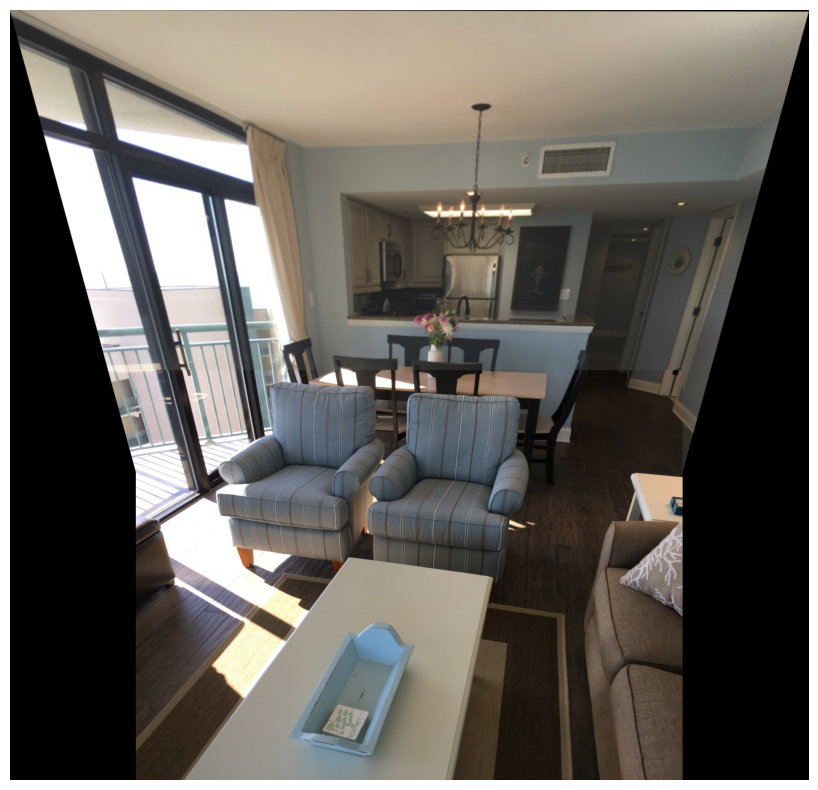

In [29]:

def concatenate_images(H, img1, img2):
    """
    Funkcija koja spaja dve slike koristeci homografiju H.

    Parametri:
    H: Homografija koja transformise img2 u koordinatni sistem img1.
    img1: Prva slika (referentna).
    img2: Druga slika (koja se transformise i spaja sa prvom).

    Povratna vrednost:
    Spojena panorama slika.
    """

    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Pronađi coskove img2 u koordinatnom sistemu img1
    corners_img2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv.perspectiveTransform(corners_img2, H)

    # Odrediti velicinu rezultujuce slike
    all_corners = np.concatenate((
        np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1,1,2), transformed_corners
    ), axis=0)

    # odrediti granice panorame sa malim pomacima radi preciznosti
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    translation = [-x_min, -y_min] # kako bi se pomerila slika u pozitivne koordinate

    H_translation = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])
    panorama = cv.warpPerspective(img2, H_translation.dot(H), (x_max - x_min, y_max - y_min)) # poslednji parametar je velicina rezultujuce slike

    panorama[translation[1]:height1 + translation[1], translation[0]:width1 + translation[0]] = img1

    draw_image(panorama)

    return panorama

panorama = concatenate_images(H, image_1, image_2)

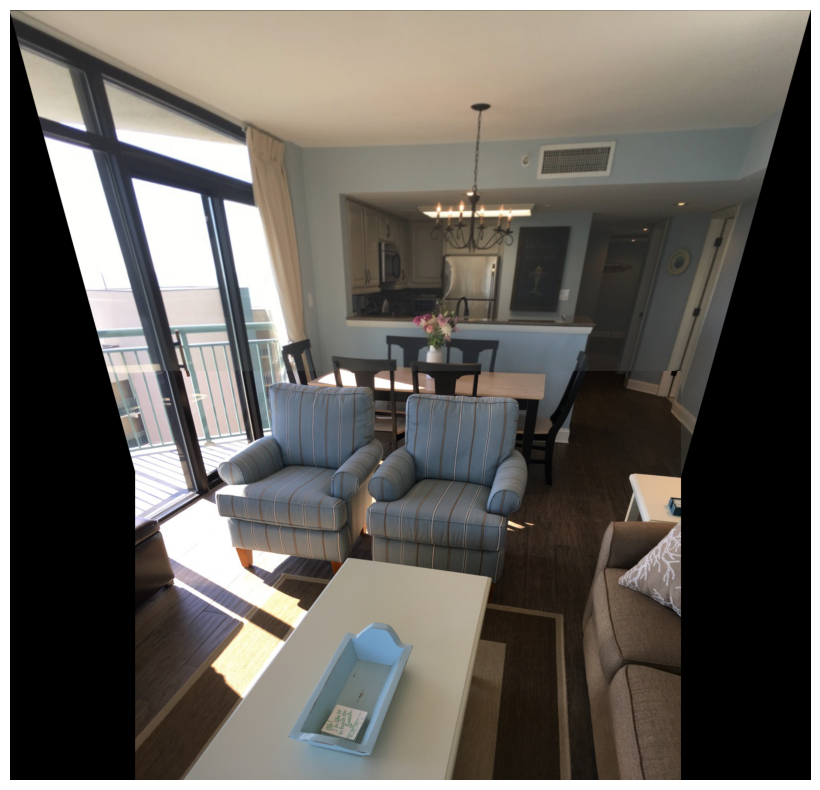

In [31]:
H_cv, mask = cv.findHomography(img_2_points, img_1_points, cv.RANSAC, 5.0)

pano_opencv = concatenate_images(H_cv, image_1, image_2)

## 3. Stapanje slika (blend)

Kada se nakon svega slike poravnaju ono sto ce se desiti jeste da ce se videti linije, odnosno ivice na mestima gde se slike spajaju koje dolaze od razlika u svetlosti, ekspoziciji i slicno.

U primeru iznad se otprilike na polovini slike jasno uocavaju takve ivice.

Potreban nam je neki nacin da stopimo slike tako da se ova razlika ne vidi.

Resenje ovog problema lezi u racunanju tezinskih funkcija koje govore o tome sa kojom tezinom se uzimaju pikseli iz koje slike.

Ako imamo dve slike $I_1, I_2$ za svaku treba da izracunamo tezinsku funkciju $\omega_1, \omega_2$.

Funkcija koju cemo koristiti: Tezina koju dodeljujemo svakom pikselu je funkcija rastojanja svakog piksela od najblize ivice slike.

Ideja je da pikseli koji su blize ivicama dobiju manje tezine.

$$
I_{blend} = w_1 * I_1 + w_2 * I_2
$$

In [32]:
def concatenate_images_and_blend(H, img1, img2):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    transformed_corners = cv.perspectiveTransform(corners_img2, H)

    all_corners = np.concatenate((
        np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2),
        transformed_corners
    ), axis=0)

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    translation = [-x_min, -y_min]

    H_translation = np.array([[1,0,translation[0]],[0,1,translation[1]],[0,0,1]])
    warped_img2 = cv.warpPerspective(img2, H_translation.dot(H), (x_max - x_min, y_max - y_min))

    panorama = np.zeros_like(warped_img2)
    panorama[translation[1]:h1+translation[1], translation[0]:w1+translation[0]] = img1

    # kreirati maske za stapanje pomocu rastojanja
    mask1 = np.zeros((y_max - y_min, x_max - x_min), dtype=np.uint8)
    mask1[translation[1]:h1+translation[1], translation[0]:w1+translation[0]] = 255

    mask2 = np.any(warped_img2 > 0, axis=2).astype(np.uint8) * 255

    dist1 = cv.distanceTransform(mask1, cv.DIST_L2, 5).astype(np.float32)
    dist2 = cv.distanceTransform(mask2, cv.DIST_L2, 5).astype(np.float32)

    # racunanje tezina na osnovu rastojanja
    weight_sum = dist1 + dist2
    weight1 = np.divide(dist1, weight_sum, out=np.zeros_like(dist1), where=weight_sum>0)
    weight2 = np.divide(dist2, weight_sum, out=np.zeros_like(dist2), where=weight_sum>0)

    # stapanje slika
    blended = panorama.astype(np.float32) * weight1[:,:,np.newaxis] + \
              warped_img2.astype(np.float32) * weight2[:,:,np.newaxis]
    blended = blended.astype(np.uint8)

    blended[(mask1==255) & (mask2==0)] = panorama[(mask1==255) & (mask2==0)]
    blended[(mask2==255) & (mask1==0)] = warped_img2[(mask2==255) & (mask1==0)]
    draw_image(blended)

    return blended

blended_pano = concatenate_images_and_blend(H, image_1, image_2)


## 4. Izvlacenje pravougaone slike

Nakon sto se slike spoje one gotovo nikad nece imati ocekivani pravougaoni oblik panorame.

Najjednostavniji pristup je da se izvuce pravougaonik maksimalne velicine koji ne sadrzi piksele pozadine (u ovom slucaju crne piksele).

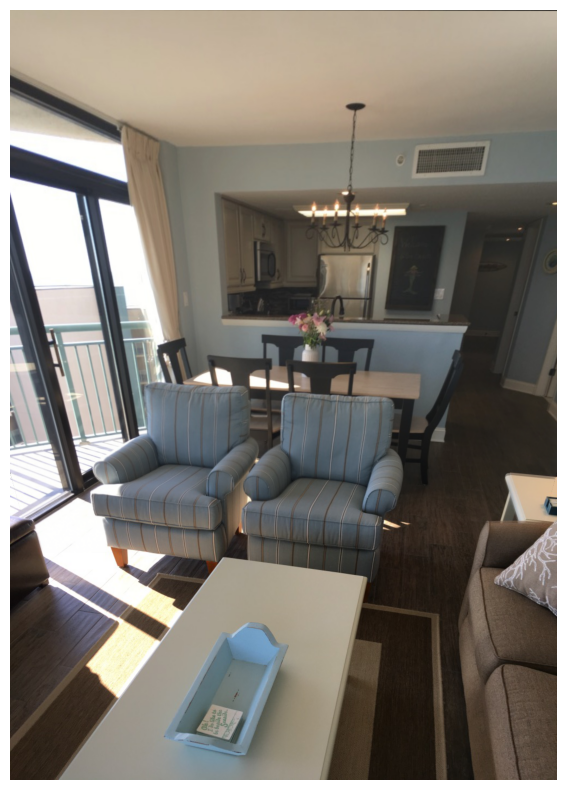

In [34]:
def max_white_rect(binary):
    rows, cols = binary.shape
    height = np.zeros((rows, cols), dtype=int)
    max_area = 0
    max_rect = (0, 0, 0, 0)

    for i in range(rows):
        for j in range(cols):
            if binary[i, j] == 1:
                height[i, j] = height[i-1, j] + 1 if i > 0 else 1

        stack = []
        j = 0
        while j <= cols:
            h = height[i, j] if j < cols else 0
            if not stack or h >= height[i, stack[-1]]:
                stack.append(j)
                j += 1
            else:
                top = stack.pop()
                width = j if not stack else j - stack[-1] - 1
                area = height[i, top] * width
                if area > max_area:
                    max_area = area
                    max_rect = (stack[-1]+1 if stack else 0, i - height[i, top]+1, width, height[i, top])

    return max_rect

# pronalazenje najveceg pravougaonika bez crnih piksela
def rectangularise_image(image):
    # konvertovanje slike u crno-belu
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    _, binary = cv.threshold(gray, 1, 1, cv.THRESH_BINARY)

    max_rect = max_white_rect(binary)
    x, y, w, h = max_rect
    cropped = image[y:y+h, x:x+w]

    draw_image(cropped)

rectangularise_image(blended_pano)

## Spajanje n slika u panoramu

Spajanje n slika uopstavanjem prethodno opisanog postupka za spajanje 2 slike.

1. Odradi se detekcija kljucnih tacaka isto kao i kod spajanja dve slike
2. Potrebno je imati informaciju o tome koje slike su susedne i imaju preklapanja kako bi se uparile kljucne tacke i izracunala homografija
3. Da bi sve slike bile u istom koordinatnom sistemu mora se odabrati referentna slika (obicno centralna slika)
4. Kada imamo referentnu sliku, kombinacijom dobijenih homografija svaka slika se transformise u koordinatni sistem referentne slike
5. Blending i izvlacenje pravougaonika se vrse na isti nacin kao i kod dve slike 

U nastavku je dat primer spajanja mnostva slika u panoramu koriscenjem openCV biblioteke.

In [35]:
images_folder = './multiple_example'

input_images = []
for filename in os.listdir(images_folder):
    img_path = os.path.join(images_folder, filename)
    img = cv.imread(img_path)

    if img is not None:
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        input_images.append(img_rgb)
    else:
        print(f"Could not read {filename}")

print(f"Total input_images loaded: {len(input_images)}")

Total input_images loaded: 7


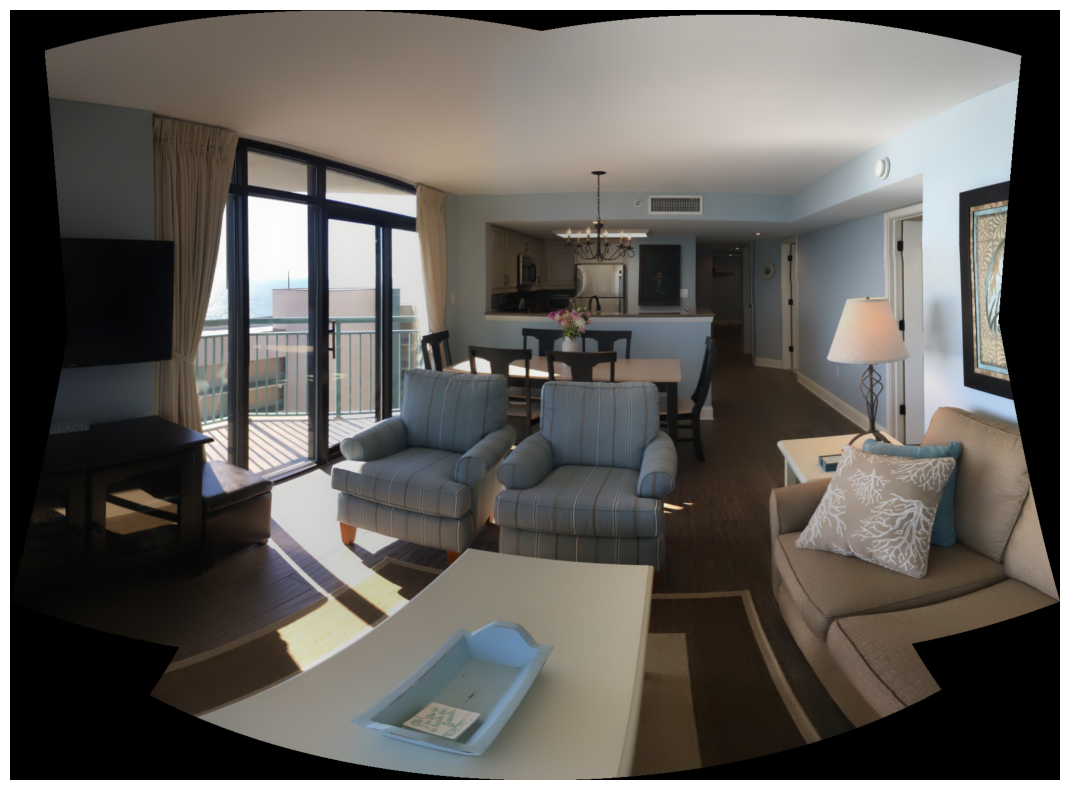

In [ ]:
stitcher = cv.Stitcher_create(cv.Stitcher_PANORAMA)
status, pano = stitcher.stitch(input_images)

if status == cv.Stitcher_OK:
    draw_image(pano)
    rectangularise_image(pano)
else:
    print("Stitching failed:", status)